In [1]:
# Importing required modules
import warnings
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from efficientnet_pytorch import EfficientNet
import torch.nn as nn
import torch
import cv2
import pandas as pd
import numpy as np
import pathlib
import os,sys
from scipy.special import softmax
from torchvision.models import resnet50
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
warnings.filterwarnings('ignore')

/opt/conda/envs/akash/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Building custom dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, X_train, y_train, transform):
        self.root_dir = root_dir
        self.transform = transform
        self.X_train = X_train
        self.y_train = y_train

    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, index):
        label = self.y_train.iloc[index]
        image_path = self.X_train.iloc[index]
        image = np.load(f'{root_dir}/{image_path}')
        image = np.squeeze(image)
        image = np.uint8(image * 255)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        image = self.transform(image)
        return image, torch.tensor(label)

In [3]:
def run():
    torch.cuda.empty_cache()
    #  Loading the train data
    test_df = pd.read_csv(test_csv_path)
    le = preprocessing.LabelEncoder()
    test_df['label'] = le.fit_transform(test_df['label'])

    # building training and validation sets
    X_test = test_df['path']
    y_test = test_df['label']
    print('Data lengths: ', len(X_test), len(y_test))

    # Data transforms
    test_transforms = transforms.Compose([transforms.ToPILImage(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])])

    # DataLoader
    valid_dataset = CustomDataset(root_dir,X_test, y_test,test_transforms)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

    # Loading the pretrained model here
    if 'efficientnet' in model_name:
        model = EfficientNet.from_pretrained(model_name)
        # print(model)
        model._fc = nn.Sequential(
            nn.Linear(mid_features, 100),
            nn.ReLU(),
            nn.Linear(100, 3)
        )
    else:
        model = resnet50(pretrained = True)
        model._fc = nn.Sequential(
            nn.Linear(mid_features, 100),
            nn.ReLU(),
            nn.Linear(100, 3)
        )
       
    for params in model.parameters():
        params.requires_grad = True

    # loading the trained weights
    model.load_state_dict(torch.load(pretrained_model)['model_state_dict'])
    
    model.eval()
    # Training model
    model.to(device)
    
    total = 0
    correct = 0
    valid_acc = 0
    label = np.array([])
    outputs = np.empty((0,3))
    
    with torch.no_grad():
        for batch_idx, data in enumerate(tqdm(valid_loader, total=len(valid_loader))):
            images, targets = data
            images = images.to(device)
            targets = targets.to(device)
            output = model(images)
            _, pred = torch.max(output, 1)
            label = np.concatenate((label, np.array(pred.cpu().data)), axis=0)
            outputs = np.concatenate((outputs, np.array(output.cpu().data)), axis=0)
            correct += (pred == targets).sum().item()
            total += pred.size(0)
    valid_acc = correct/total * 100
    print(f'Valid Accuracy: {valid_acc}', end = '\r')
#     print(output)
    return X_test, y_test, label, outputs

In [4]:
# This helps make all other paths relative
base_path = pathlib.Path().absolute()
# Model choice
# arg:  efficientnet-b0, efficientnet-b3, efficientnet-b4, efficientnet-b5, efficientnet-b6, efficientnet-b7, resnet50
model_name = 'efficientnet-b6'
pretrained_model = f'checkpoint_30_efficientnet-b6.pth.tar'
# Input of the required hyperparameters
BATCH_SIZE = 128
# 1280, 1536, 1792, 2048, 2304, 2048
mid_features = 2304
num_workers = 2
device = 'cuda:7' if torch.cuda.is_available() else 'cpu'
base_path = '.'
root_dir = base_path
if not os.path.exists(f'{root_dir}/dataset'):
    print("Dataset missing.")
    print(f'{root_dir}/dataset')
    sys.exit()
test_csv_path = f'{base_path}/val_data.csv'

X_test, y_test, label, outputs = run()

Data lengths:  7500 7500
Loaded pretrained weights for efficientnet-b6


100%|██████████| 59/59 [00:08<00:00,  6.60it/s]

In [5]:
y_test = np.array(y_test)
label = np.array(pd.Series(label).astype(int))
outputs = softmax(outputs, axis=1)
y_pred = pd.get_dummies(pd.Series(label))
auc_score = roc_auc_score(y_test, outputs, multi_class='ovo')


In [6]:
f1 = f1_score(y_true = y_test, y_pred = label,average = 'macro')

AUC:  0.9898181866666667
F1_score:  0.9460722597153678


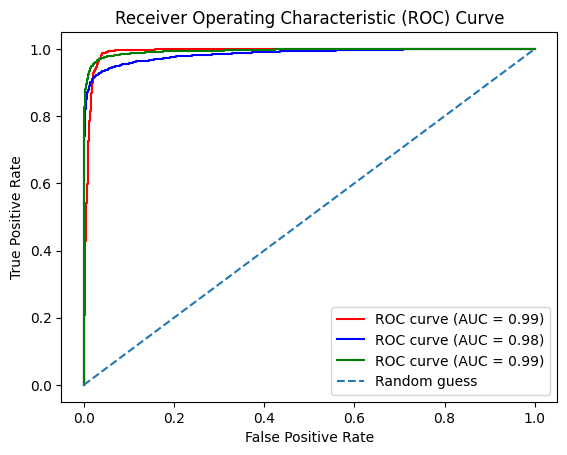

In [7]:
# calculate false positive rate and true positive rate for each class at various probability thresholds
print("AUC: ", auc_score)
print("F1_score: ", f1)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, outputs[:,i])
    roc_auc[i] = roc_auc_score(y_test == i, outputs[:, i])

# plot the ROC curve for each class
plt.figure()
colors = ['red', 'blue', 'green']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, label=f'ROC curve (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()